<a href="https://colab.research.google.com/github/pabloac31/TFG/blob/master/ImageNet_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Clone the repository**

In [1]:
! git clone https://github.com/pabloac31/TFG.git
%cd TFG

Cloning into 'TFG'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 305 (delta 72), reused 31 (delta 16), pack-reused 183
Receiving objects: 100% (305/305), 219.46 MiB | 20.09 MiB/s, done.
Resolving deltas: 100% (165/165), done.
Checking out files: 100% (31/31), done.
/content/TFG


**Using TensorFlowV1**

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


**Import libraries**

In [3]:
from adversarial_attacks import *
import torchvision.models as models
import json

**Use CUDA if available**

In [4]:
# Define what device we are using
use_cuda=True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


**Get the names of ImageNet classes**

In [5]:
with open('imagenet_class_index.json') as f:
  class_idx = json.load(f)

**Load the desired model**

In [6]:
model = models.resnet50(pretrained=True)
#model = models.densenet169(pretrained=True)
#model = models.mobilenet_v2(pretrained=True)
#model = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


**Load and image from its url**

In [13]:
img = torch.unsqueeze(image_loader('https://images.freeimages.com/images/large-previews/4ec/banana-s-1326714.jpg'), dim=0)
img = img.to(device)

**Use the previous model to classify the image**

In [14]:
model.eval()
model = model.to(device)
img.requires_grad = True

output = model(img)
pred = output.max(1, keepdim=True)[1]
print('Input image classified as', class_idx[str(pred.item())][1], end='')
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
print(' with a {:.2f}% confidence'.format(percentage[pred].item()))

Input image classified as banana with a 99.53% confidence


**Show the image with its label and confidence**

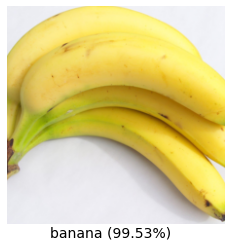

In [15]:
f = plt.figure()
plt.axis('off')
#f.text(.50, .08, class_idx[str(pred.item())][1] + ' [99,93,99,100]%', ha='center', fontsize=14)
f.text(.50, .08, class_idx[str(pred.item())][1] + ' ({:.2f}%)'.format(percentage[pred].item()), ha='center', fontsize=14)
plt.imshow(displayable(img.clone().detach().cpu(), dataset='imagenet'))

**Compute an adversarial image.**
Select the method you want to use

In [16]:
t0= time.clock()

## FGSM
#adv_x, _ = fgsm(model, img, pred[0], output, epsilon=0.64, clip=False, dataset='imagenet')

## DeepFool 
_, adv_x, _, n_iter = deepfool(model, device, img, num_classes=100, lambda_fac=1.02, p=2, dataset='imagenet')

## SparseFool
#lb, ub =  valid_bounds(img, 255, dataset='imagenet')
#lb = lb[None, :, :, :].to(device)
#ub = ub[None, :, :, :].to(device)
#adv_x, pert_x, n_iter = sparsefool(model, device, img, pred.item(), lb, ub, max_iter=50)

## One Pixel Attack
#adv_x, n_iter, scores = one_pixel_attack(model, device, img, pred.item(), pop_size=1000, d=1000, dataset='imagenet')

t1 = time.clock() - t0
print("Time elapsed: {:.2f} seconds".format(t1)) # CPU seconds elapsed 

Time elapsed: 40.11


**Classify the adversarial image**

In [17]:
output = model(adv_x)
pred = output.max(1, keepdim=True)[1]
print('Adversarial image classified as', class_idx[str(pred.item())][1], end='')
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
print(' with a {:.2f}% confidence'.format(percentage[pred].item()))

Adversarial image classified as butternut_squash with a 34.90% confidence


**Show the adversarial image with its label and confidence**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.08, 'butternut_squash (34.90%)')

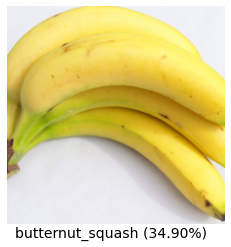

In [18]:
f = plt.figure()
plt.axis('off')
plt.imshow(displayable(adv_x.clone().detach().cpu(), dataset='imagenet'))
f.text(.50, .08, class_idx[str(pred.item())][1] + ' ({:.2f}%)'.format(percentage[pred].item()), ha='center', fontsize=14)

*Optional:* create a noisy image adding random noise to the original image for comparison

In [ ]:
k = (abs(img-adv_x)).max().item() 
#k = 0.1
rnd_img = img + k*torch.randn_like(img)
output = model(rnd_img)
pred = output.max(1, keepdim=True)[1]
print('Noisy image classified as', class_idx[str(pred.item())][1], end='')
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
print(' with a {:.2f}% confidence'.format(percentage[pred].item()))

Show the noisy image

In [ ]:
f = plt.figure()
plt.axis('off')
f.text(.50, .08, class_idx[str(pred.item())][1] + ' ({:.2f}%)'.format(percentage[pred].item()), ha='center', fontsize=14)
plt.imshow(displayable(rnd_img.clone().detach().cpu(), dataset='imagenet'))

View the activations produced by the original, adversarial and noisy images.
Shows the euclidean distance between its features in each group of layers of the network.

In [ ]:
x = img.clone()
adv = adv_x.clone()
rnd = rnd_img.clone()
print("Initial adv distance {:.4f}".format((x-adv).norm().item()))
print("Initial rnd distance {:.4f}".format((x-rnd).norm().item()))

#for i, l in enumerate(model._modules['features']):
for i, l in enumerate(list(model.children())[:-1]):  # for ResNet
  print("\nBlock",i)
  #print("\n", l, "\n")
  #print("Input size: ", x.size())
  x = l(x)
  adv = l(adv)
  rnd = l(rnd)
  #print("Output size: ", x.size())

  dist_adv = 0
  dist_rnd = 0
  max_adv = 0
  max_rnd = 0

  j = 0
  max_adv_idx, max_rnd_idx = 0, 0

  for d_x, d_adv, d_rnd in zip(x[0], adv[0], rnd[0]):
    norm_adv = (d_x - d_adv).norm().item()
    norm_rnd = (d_x - d_rnd).norm().item()
    dist_adv += norm_adv
    dist_rnd += norm_rnd
    if norm_adv > max_adv:
      max_adv = norm_adv
      max_adv_idx = j
    if norm_rnd > max_rnd:
      max_rnd = norm_rnd
      max_rnd_idx = j

    j += 1


  print("\nAvg adv distance {:.4f}".format(dist_adv / x.size(1)))
  print("Avg rnd distance {:.4f}".format(dist_rnd / x.size(1)))

  print("\nMax adv distance {:.4f}".format(max_adv))
  print("Max rnd distance {:.4f}".format(max_rnd))

  plt.imshow(x[0][max_adv_idx].clone().detach().cpu())
  plt.show()
  plt.imshow(adv[0][max_adv_idx].clone().detach().cpu())
  plt.show()
  plt.imshow(rnd[0][max_adv_idx].clone().detach().cpu())
  plt.show()